In [1]:
import sys
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("/home/kirilman/Project/asbestos/")
from dataset import ImageDirDataset
from dataset import get_paths
%matplotlib inline
from pathlib import Path
import os
import pandas as pd

/home/kirilman/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

/home/kirilman/miniconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [14]:
path_2_model = '/home/kirilman/Project/asbestos/yolov5/runs/train/without_aug_l/weights/best.pt'
model = torch.hub.load('../../yolov5', 'custom', path=path_2_model, source='local') 

YOLOv5 🚀 v6.1-295-gf8722b4 Python-3.9.12 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5947MiB)

Fusing layers... 
Model summary: 367 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
Adding AutoShape... 


In [15]:
for i,m in enumerate(model.model.model.model):
    W = list(m.parameters())
    print(i,W[0].shape,W[1].shape, len(W))

0 torch.Size([64, 3, 6, 6]) torch.Size([64]) 2
1 torch.Size([128, 64, 3, 3]) torch.Size([128]) 2
2 torch.Size([64, 128, 1, 1]) torch.Size([64]) 18
3 torch.Size([256, 128, 3, 3]) torch.Size([256]) 2
4 torch.Size([128, 256, 1, 1]) torch.Size([128]) 30
5 torch.Size([512, 256, 3, 3]) torch.Size([512]) 2
6 torch.Size([256, 512, 1, 1]) torch.Size([256]) 42
7 torch.Size([1024, 512, 3, 3]) torch.Size([1024]) 2
8 torch.Size([512, 1024, 1, 1]) torch.Size([512]) 18
9 torch.Size([512, 1024, 1, 1]) torch.Size([512]) 4
10 torch.Size([512, 1024, 1, 1]) torch.Size([512]) 2


IndexError: list index out of range

In [22]:
W = list(model.model.model.model[7].conv.parameters())[0][0].cpu().detach().numpy()
# W.reshape(-1)
W.shape

(512, 3, 3)

### Распределение весов

(array([         16,         147,         828,        1669,        1366,         467,          95,          15,           3,           2]),
 array([     -0.066,   -0.048971,   -0.031943,   -0.014914,    0.002114,    0.019142,    0.036171,    0.053199,    0.070228,    0.087256,     0.10428], dtype=float32),
 <BarContainer object of 10 artists>)

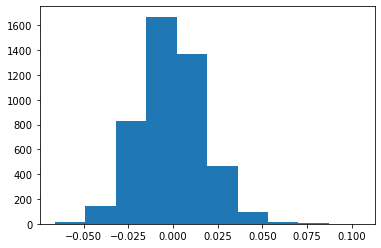

In [23]:
fig = plt.figure()
plt.hist(W.reshape(-1))

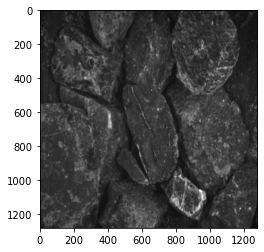

In [24]:
dataset = ImageDirDataset('/home/kirilman/Project/dataset/')
img = dataset[338]['image']/255
plt.imshow(img)

In [25]:
img = cv2.resize(img, (512,512))
source_img = img.copy()
img = img.transpose((2, 0, 1))[::-1]
img = np.ascontiguousarray(img)
test_img = torch.tensor(img, dtype = torch.float).unsqueeze(0)
test_img.shape

torch.Size([1, 3, 512, 512])

In [26]:
y_hat = model(test_img)
print(y_hat)
print(y_hat.shape, y_hat[0][1])

tensor([[[6.66347e+00, 5.28284e+00, 1.96818e+01, 1.53571e+01, 5.68100e-07, 9.99997e-01],
         [1.35905e+01, 5.21871e+00, 2.70370e+01, 9.41397e+00, 7.84781e-06, 9.99998e-01],
         [1.84064e+01, 5.01302e+00, 3.02722e+01, 7.93131e+00, 2.66063e-07, 9.99997e-01],
         ...,
         [4.36783e+02, 4.80670e+02, 2.19649e+02, 1.33274e+02, 9.83030e-05, 9.99998e-01],
         [4.56778e+02, 4.85626e+02, 2.24819e+02, 1.50490e+02, 1.71032e-05, 9.99998e-01],
         [4.96331e+02, 4.87303e+02, 2.03771e+02, 2.06094e+02, 7.21926e-06, 9.99998e-01]]], device='cuda:0')
torch.Size([1, 16128, 6]) tensor([1.35905e+01, 5.21871e+00, 2.70370e+01, 9.41397e+00, 7.84781e-06, 9.99998e-01], device='cuda:0')


In [27]:
from yolov5.utils.general import non_max_suppression
from tools.plots import plot_bboxs
from yolov5.utils.general import xywhn2xyxy, xywh2xyxy, xyxy2xywh

In [29]:
pred = non_max_suppression(y_hat, 0.6)[0].cpu().detach().numpy()
print(len(pred))
# print(pred[12])

11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


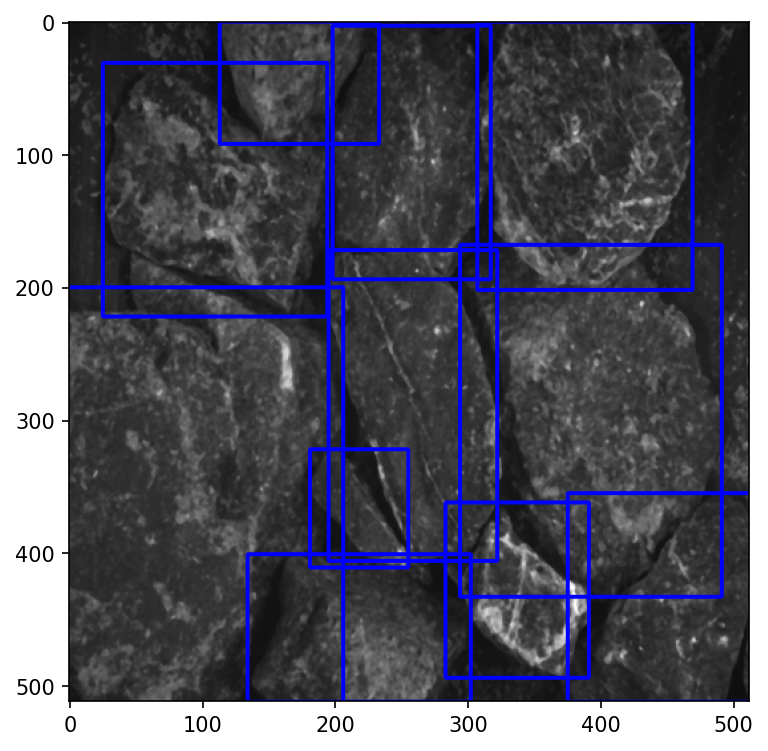

In [30]:
result = plot_bboxs(source_img, pred[:,:4]/512, color=[0., 0., 255])
fig = plt.figure(dpi= 150,figsize = (6,6))
plt.imshow(result)

### Сжатое представление изображения в сети

In [31]:
!rm -r ./features2/*


rm: невозможно удалить './features2/*': Нет такого файла или каталога


In [32]:
def extraced_features(x,model, n_layer = 3):
    """
        Feature map for image on n'th layers of network
    """
    x = x
    for i, m in enumerate(model.model.model.model):
        x=m(x)
        if i == n_layer:
            return x

In [ ]:

image = dataset[0]['image']
print(image.shape)
features = extraced_features(preprocessing_input(image),model, n_layer = 10).detach().numpy()
print(features.shape)
fig,ax = plt.subplots(3,4, dpi = 100, figsize=(10,10))
ax[0][0].imshow(features[0].mean(0))
ax[0][1].imshow(features[0][0])
ax[0][2].imshow(features[0][1])

ax[1][0].imshow(features[0][16])
ax[1][1].imshow(features[0][17])
ax[1][2].imshow(features[0][18])

ax[2][0].imshow(features[0][-1])
ax[2][1].imshow(features[0][-2])
ax[2][2].imshow(features[0][-3])
ax[0][3].imshow(cv2.resize(image, (512,512))/255)

In [38]:
def preprocessing_input(img):
    inpt = img.copy()
    inpt = cv2.resize(inpt, (512,512))
    inpt = inpt.transpose((2, 0, 1))[::-1]
    inpt = np.ascontiguousarray(inpt)
    inpt = torch.tensor(inpt)
    return inpt.unsqueeze(0)
dataset = ImageDirDataset('/home/kirilman/Project/dataset/test transport')

In [ ]:
features = {}
for i in range(len(dataset)):
    s =  dataset[i]
    img = s['image']/255
    f = extraced_features(preprocessing_input(img), model)[0][0]
    feature = f.detach().numpy().reshape(-1)
    p = Path(s['name'])
    np.save('./features2/' + (str(p.parent).split('/')[-1] +'#'+str(p).split('/')[-1]).split('.')[0] + '.npy', feature)
    if i%100 == 0:
        print(i, s['name'])

In [40]:
s =  dataset[i]
img = s['image']/255
preprocessing_input(img).shape

torch.Size([1, 3, 512, 512])

In [41]:
def distance(v1,v2):
    return np.sqrt(np.sum((v2 - v1)**2))
root = './features2/'
files = os.listdir(root)
n = len(files)
R = np.zeros((n,n)) + 1000
vectors = {f:np.load(root+f) for f in files}

In [42]:
for i,f1 in enumerate(files):
    for k, f2 in enumerate(files):
        if f1 != f2:
            v1 = vectors[f1]
            v2 = vectors[f2]
            R[i][k] = distance(v1,v2)
    
    if i%1000==0:
        print(i)

In [43]:
files[6]

IndexError: list index out of range

In [84]:
pd.DataFrame(R).to_csv('R.csv')

(0.0, 25.0)

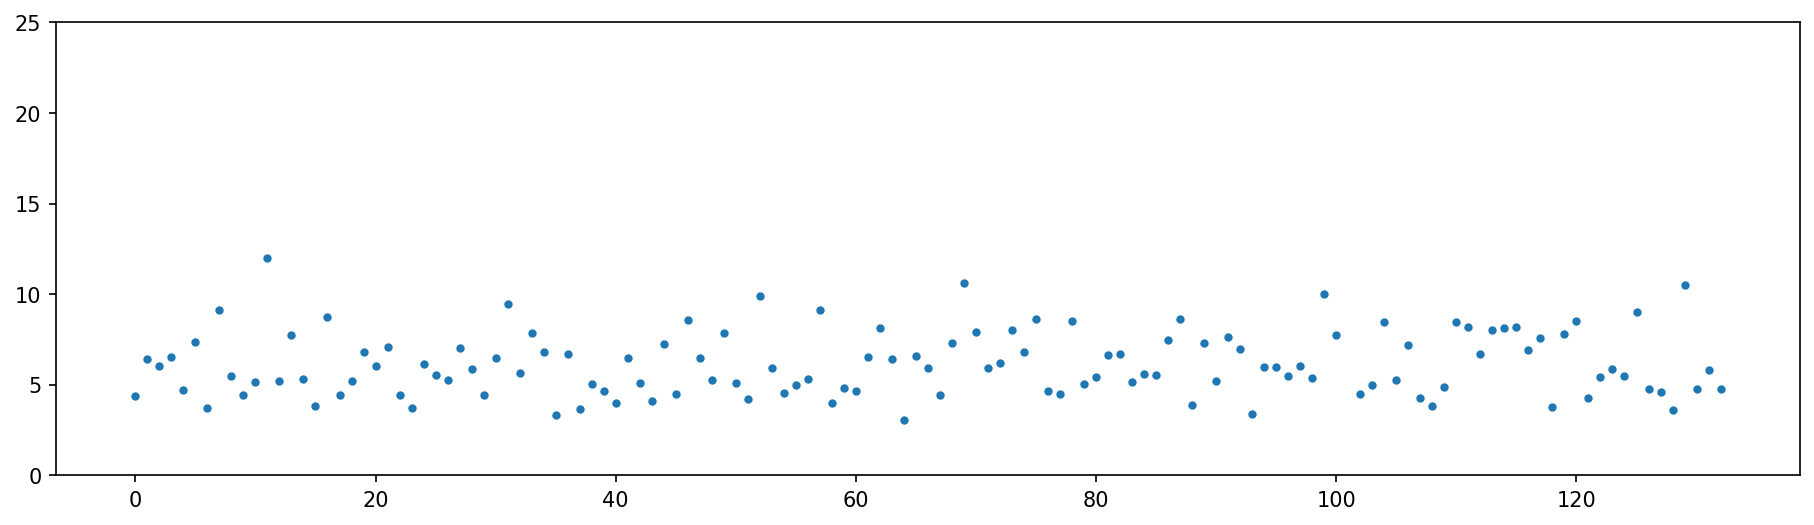

In [104]:
fig = plt.figure(dpi= 150,figsize = (15,4))
plt.plot(R[102][1:],'.')
plt.ylim(0,25)

In [64]:
from dataset import get_paths

In [65]:
paths = get_paths('/home/kirilman/Project/dataset/test transport')
merges_images

['Detailed#20-04-2021-14-54-12_30_2_81_detailed.npy',
 'Detailed#20-04-2021-14-52-23_19_2_87_detailed.npy',
 'Detailed#20-04-2021-14-54-46_34_2_95_detailed.npy',
 'Detailed#20-04-2021-14-52-40_21_2_93_detailed.npy',
 'Detailed#20-04-2021-14-49-56_6_2_60_detailed.npy',
 'Detailed#20-04-2021-14-15-25_12_1_94_detailed.npy',
 'Detailed#20-04-2021-15-37-26_30_3_76_detailed.npy']

ipt file images#15_12_11_06_16-03-2020_1.npy
[     3.8343      4.0287      4.5409      4.5045      4.9164      3.6777      4.8733      4.5888       4.556       3.525      3.5782      4.8694      4.5357      4.5001      4.7372      4.8172      4.0896      4.0891       4.797      4.5694      3.8653      4.7027      4.8231      4.7853      4.3738         4.7
      3.6014      4.0539      4.6481      4.7975      4.3568      4.8921      4.7693      4.7667      4.6746      4.7735      3.9311      4.2082       2.771      4.8464      4.8856      4.6399      3.9507      4.6537      4.1593      4.3042      4.2389      3.7731]
7
6_12_32_19_05-03-2020_1 /home/kirilman/Project/dataset/test transport/images/6_12_32_19_05-03-2020_1.jpg
15_12_10_47_16-03-2020_1 /home/kirilman/Project/dataset/test transport/images/15_12_10_47_16-03-2020_1.jpg
25_13_31_07_16-03-2020_1 /home/kirilman/Project/dataset/test transport/images/25_13_31_07_16-03-2020_1.jpg
24_13_28_55_16-03-2020_1 /home/kirilman/Project/dataset

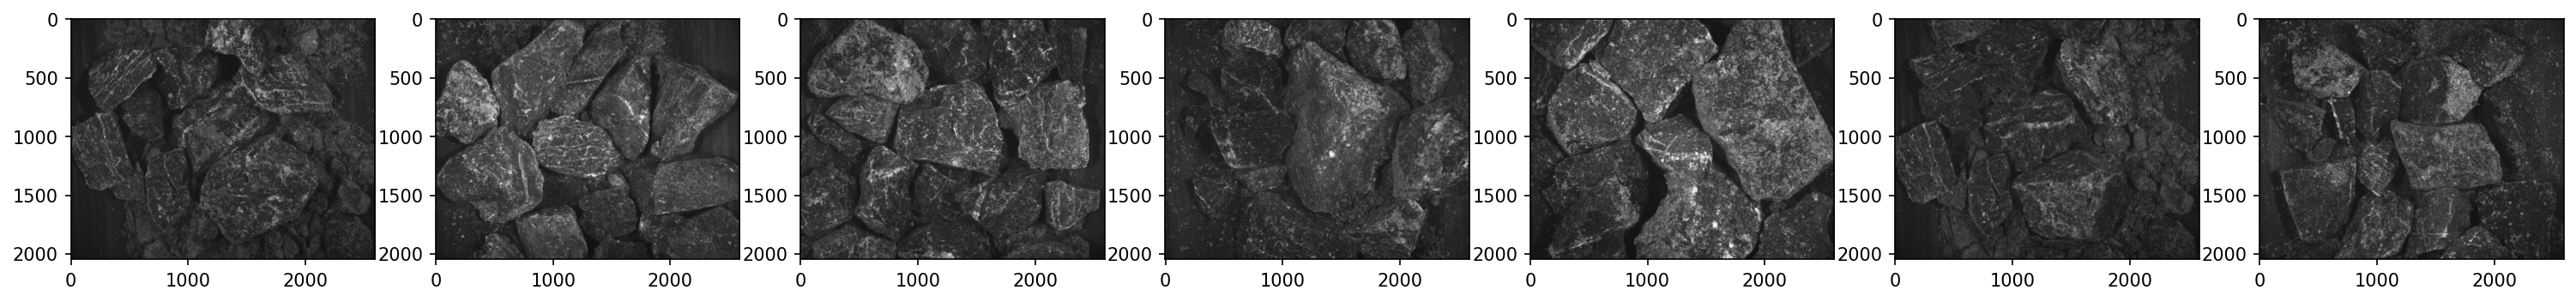

In [95]:
N = 104
line = R[N][1:]
print('ipt file', files[N])
indexs = np.where(line<5)[0]
print(line[indexs])
i = 0
f, ax = plt.subplots(1,7, dpi = 150,figsize = (25,4))

merges_images = [files[ind] for ind in indexs][:7]
print(len(merges_images))
for f_neig in merges_images:
    for p in paths:
        img_sub_name = f_neig.split('#')[-1].split('.')[0]
        if img_sub_name in p:
            img = cv2.imread(p)
            ax[i].imshow(img)
            i+=1
            print(img_sub_name, p)

In [35]:
[files[ind] for ind in indexs]

['Detailed#20-04-2021-14-07-11_35_1_87_detailed.npy',
 'Detailed#20-04-2021-14-29-31_13_1_88_detailed.npy',
 'Detailed#20-04-2021-14-04-13_18_1_92_detailed.npy',
 'Detailed#20-04-2021-14-16-50_19_1_81_detailed.npy',
 'Detailed#20-04-2021-15-03-35_17_2_90_detailed.npy',
 'Detailed#20-04-2021-15-01-37_6_2_62_detailed.npy',
 'Detailed#20-04-2021-14-07-58_39_1_70_detailed.npy']

In [42]:
R.shape

(330, 330)

In [43]:
%matplotlib inline

In [21]:
class Computer:
    def __init__(self, name:str):
        self.name = name
        self.clock:str= "3500"
        self._memory:int = 15
        
    @property
    def memory(self):
        return self._memory
    
    @memory.setter
    def memory(self, value:int):
        self._memory = value

cpu = Computer('Intel')
cpu.memory = 15
cpu.memory

15